In [1]:
import common

import tensorflow as tf
import mixturemapping as mm
import numpy as np

### Define train data

In [2]:
mixN = 3 #dimension of Gaussian Mixture
inputMixM = 2 #dimension of single Gaussian in the input mixture
outputMixM = 3 #dimension of a single Gaussian in the output mixture
sampleSize = 200
batchSize = 50
dataType = tf.float32

In [3]:
trainFeatures = common.getSimpleLinearA(
    mixN,
    inputMixM,
    outputMixM,
    sampleSize
)

In [4]:
trainFeatures.keys()

dict_keys(['InputMean', 'InputStdDev', 'InputWeights', 'TrainSamples', 'InputSamples', 'TrainMean', 'TrainStdDev', 'TrainWeights', 'OutputMean', 'OutputCovs', 'OutputWeights', 'GroupedSamples', 'GroupedInputSamples', 'testFeatures'])

### Create Model

In [17]:
tf.keras.backend.clear_session()


with tf.name_scope("WaferGMM"):
    inMeans = tf.keras.Input(shape=(mixN, inputMixM),
                             name="Means", dtype=dataType)
    inStdDevs = tf.keras.Input(
        shape=(mixN, inputMixM), name="StdDevs", dtype=dataType)
    inWeight = tf.keras.Input(shape=(mixN), name="Weights", dtype=dataType)


with tf.name_scope("OutputGMM"):
    outMeans = tf.keras.Input(shape=(mixN, outputMixM),
                              name="outMeans", dtype=dataType)
    outCovs = tf.keras.Input(
        shape=(mixN, outputMixM, outputMixM), name="outCovs", dtype=dataType)
    outWeights = tf.keras.Input(
        shape=(mixN), name="outWeights", dtype=dataType)


with tf.name_scope("CoreModel"):
    covALayer = mm.layers.VarCovMatrix(outputMixM, name="CovA")
    covA = covALayer(inMeans)

    mappingLayer = mm.layers.LinearMapping(
        outputMixM, name="Mapping", dtype=dataType)
    newDist = mappingLayer(
        {'means': inMeans, 'stdDevs': inStdDevs, 'weights': inWeight, 'covA': covA})

    distLayer = mm.layers.Distribution(
        dtype=dataType, regularize_cov_epsilon=0.95)

    dist = distLayer(newDist)

    loss = mm.layers.DistributionKLLoss(symmetric=True, n_samples=200)(
        {
            "dist": dist,
            "means": outMeans,
            "covariances": outCovs,
            "weights": outWeights
        })

    outputMeans = mm.layers.DistributionMean()(loss["dist"])


In [18]:
model = tf.keras.Model(inputs=[inMeans, inStdDevs, inWeight, outMeans, outCovs, outWeights], outputs=outputMeans)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Means (InputLayer)             [(None, 3, 2)]       0           []                               
                                                                                                  
 CovA (VarCovMatrix)            (None, 3, 3)         10          ['Means[0][0]']                  
                                                                                                  
 StdDevs (InputLayer)           [(None, 3, 2)]       0           []                               
                                                                                                  
 Weights (InputLayer)           [(None, 3)]          0           []                               
                                                                                              

### Train the model

In [20]:
mappingLayer.sampling_ON()
covALayer.sampling_ON()

optimizer = tf.optimizers.Adam()

initial_learning_rate = 0.01

def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.001)

optimizer = tf.optimizers.Adam(learning_rate=initial_learning_rate)

In [21]:
model.compile(optimizer=optimizer)

In [22]:
callbacks = [
    tf.keras.callbacks.LearningRateScheduler(scheduler),

    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        patience=200,
        verbose=1,
        restore_best_weights=True
    )
]

In [23]:
for i in range(2):
    hist = model.fit(x={
            "Means": trainFeatures["InputMean"],
            "StdDevs": trainFeatures["InputStdDev"],
            "Weights": trainFeatures["InputWeights"],
            "outMeans": trainFeatures["OutputMean"],
            "outCovs": trainFeatures["OutputCovs"],
            "outWeights": trainFeatures["OutputWeights"],            
        },
        
        shuffle=True, validation_split=0.1, 
        epochs=5000, batch_size=300, 
        verbose=False, use_multiprocessing=False, 
        callbacks=callbacks
        )
    mappingLayer.sampling_OFF()


Restoring model weights from the end of the best epoch: 90.
Epoch 290: early stopping
Restoring model weights from the end of the best epoch: 2089.
Epoch 2289: early stopping


In [30]:
covALayer.sampling_OFF()
hist = model.fit(x={
        "Means": trainFeatures["InputMean"],
        "StdDevs": trainFeatures["InputStdDev"],
        "Weights": trainFeatures["InputWeights"],
        "outMeans": trainFeatures["OutputMean"],
        "outCovs": trainFeatures["OutputCovs"],
        "outWeights": trainFeatures["OutputWeights"],            
    },
    
    shuffle=True, validation_split=0.1, 
    epochs=5000, batch_size=300, 
    verbose=False, use_multiprocessing=False, 
    callbacks=callbacks
    )

Restoring model weights from the end of the best epoch: 372.
Epoch 572: early stopping


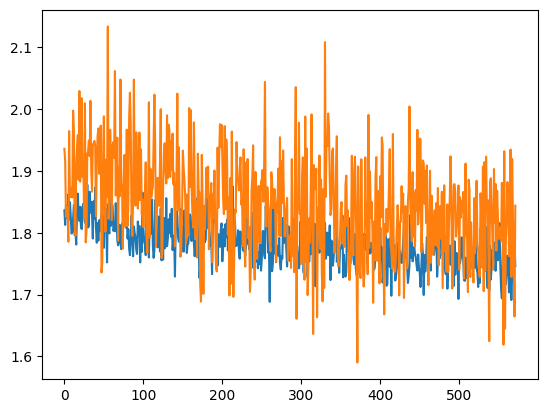

In [31]:
import matplotlib.pyplot as plt
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])

### Test model save and load

In [32]:
model2 = tf.keras.Model(inputs=[inMeans, inStdDevs, inWeight], outputs=newDist)

model2.save("savedmodel")
model3 = tf.keras.models.load_model("savedmodel")

modelSamples = mm.layers.DistributionSamples(100)(
    mm.layers.Distribution()(
        model3([inMeans, inStdDevs, inWeight])
    )
)

model4 = tf.keras.Model(inputs=[inMeans, inStdDevs, inWeight], outputs=modelSamples)

### Test trained model visually

In [33]:
res = model4.predict([trainFeatures["InputMean"], trainFeatures["InputStdDev"], trainFeatures["InputWeights"]])

4/4 [==============================] - 2s 4ms/step


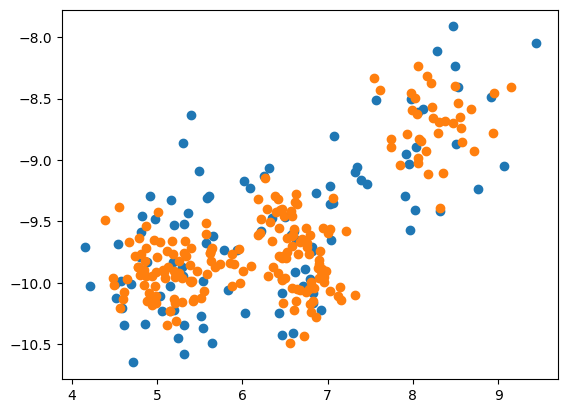

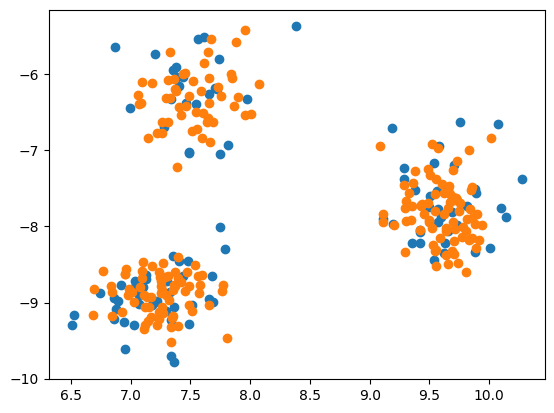

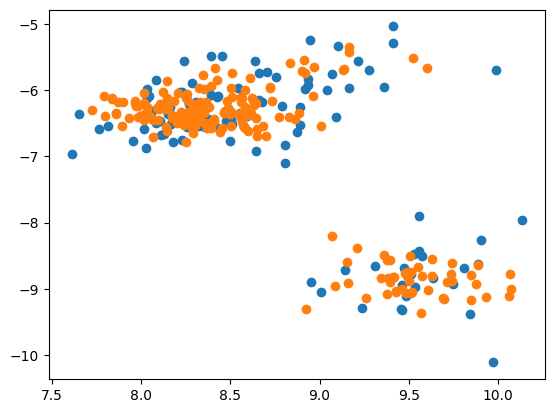

In [34]:
for idx in range(3):
    plt.scatter(x=res[idx][0,:], y=res[idx][1,:])
    plt.scatter(x=trainFeatures["GroupedSamples"][idx][0,:], y=trainFeatures["GroupedSamples"][idx][1,:])
    plt.show()

### Compare Model with train input

In [35]:
delta = tf.keras.backend.eval(
    mappingLayer.kernel.mean() - trainFeatures["testFeatures"]["mapping_kernel"]
)
print(delta)
max_delta = np.max(np.abs(delta))
print(max_delta)
assert max_delta < 0.05, "Mapping slope off"

[[-0.00714946  0.00951726  0.01115534]
 [ 0.00329578  0.01362032  0.00260231]]
0.013620317


In [36]:
delta = tf.keras.backend.eval(
    mappingLayer.bias.mean() - trainFeatures["testFeatures"]["mapping_bias"]
)
print(delta)
max_delta = np.max(np.abs(delta))
print(max_delta)
assert max_delta < 0.4, "mapping bias off"


[ 0.03933752 -0.18990001 -0.11768059]
0.18990001
